# Dimensionality Reduction using PCA by City

Following the [Exploratory Data Analysis (EDA)](https://github.com/rodolfoplng/Portfolio/blob/main/Grocery%20Store%20EDA.ipynb) and [Customer Clustering](https://github.com/rodolfoplng/Portfolio/blob/main/Machine%20Learning/K-Means/Customer%20Segmentation%20K-Means%20RFM.ipynb) on the Grocery Store Sales Dataset, we extend the analysis to a city-level comparison.

The RFM features are first aggregated by cityname, and then Principal Component Analysis (PCA) is applied. PCA reduces the three-dimensional RFM space into two principal components (PC1 and PC2) that capture the majority of the variance in the data.

This dimensionality reduction enables a clearer visualization of city-level similarities and differences, highlighting potential geographic patterns in customer purchasing behavior.

## Imports & display options

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine

pd.set_option("display.float_format", "{:,.2f}".format)

%matplotlib inline
plt.style.use("seaborn-v0_8")
sns.set_palette("viridis")

## Build the RFM table from the grocery store database

In [16]:
# Database credentials
db_user = "pguser"
db_pass = "pgpass"
db_host = "localhost"   # use "db" if running inside Docker
db_port = "5432"
db_name = "grocery"

# Create engine with default search_path
engine = create_engine(
    f"postgresql+psycopg2://{db_user}:{db_pass}@{db_host}:{db_port}/{db_name}",
    connect_args={"options": "-c search_path=raw,public"}
)

sql = """SELECT s.salesid, s.customerid, c.cityid, ci.cityname, p.productid, p.productname, 
s.quantity, s.discount, (p.price * s.quantity) as revenue, s.salesdate
FROM sales s
INNER JOIN customers c ON s.customerid = c.customerid
INNER JOIN cities ci ON c.cityid = ci.cityid
INNER JOIN products p ON s.productid = p.productid
WHERE s.salesdate >= '2018-01-01'
  AND s.salesdate <= '2018-04-30'
  AND s.quantity > 0"""

df = pd.read_sql(sql, engine)
df.head()

,salesid,customerid,cityid,cityname,productid,productname,quantity,discount,revenue,salesdate
0,1,27039,54,Albuquerque,381,Vaccum Bag 10x13,7,0.00,309.61,2018-02-05 07:38:25.430
1,2,25011,71,Phoenix,61,Sardines,7,0.00,437.85,2018-02-02 16:03:31.150
2,4,73966,45,Dallas,176,Smirnoff Green Apple Twist,19,0.20,"1,545.08",2018-04-07 14:43:55.420
3,5,32653,82,Charlotte,310,Coffee - Dark Roast,9,0.00,719.82,2018-02-12 15:37:03.940
4,6,28663,31,Wichita,413,Ice Cream Bar - Oreo Cone,8,0.00,763.28,2018-02-07 10:33:24.990


In [17]:
# Aggregate RFM metrics by city
rfm_city = (
    df.groupby("cityname")
      .agg(
          recency=("salesdate", lambda x: (df["salesdate"].max() - x.max()).days),
          frequency=("salesid", "count"),
          monetary=("revenue", "sum")
      )
      .reset_index()
)

rfm_city.head()

,cityname,recency,frequency,monetary
0,Akron,0,62479,"41,048,261.05"
1,Albuquerque,0,64451,"43,728,413.00"
2,Anaheim,0,65661,"43,486,083.93"
3,Anchorage,0,64839,"43,040,434.08"
4,Arlington,0,63962,"43,546,664.98"


## Standardize features

In [19]:
features = ["recency", "frequency", "monetary"]
scaler = StandardScaler()
rfm_city_scaled = scaler.fit_transform(rfm_city[features])

rfm_city_scaled[:5]  # preview

array([[ 0.        , -1.02429142, -1.09813883],
       [ 0.        ,  0.09226809,  0.95478278],
       [ 0.        ,  0.77737814,  0.76916548],
       [ 0.        ,  0.31195627,  0.42781013],
       [ 0.        , -0.18460696,  0.81556887]])

## Apply PCA (2 components)

In [21]:
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(rfm_city_scaled)

pca_result[:5]  # preview

array([[-1.50078482,  0.052218  ],
       [ 0.74037678, -0.60988999],
       [ 1.09357148,  0.00580723],
       [ 0.52309384, -0.08192105],
       [ 0.44615745, -0.70723111]])

### Add PCA results to DataFrame

In [23]:
rfm_city["PC1"] = pca_result[:, 0]
rfm_city["PC2"] = pca_result[:, 1]

In [24]:
# Explained variance
explained_var = pca.explained_variance_ratio_.sum() * 100
print(f"PCA explains {explained_var:.2f}% of total variance.")

PCA explains 100.00% of total variance.


C:\Users\rodol\AppData\Local\Temp\ipykernel_3784\2380288781.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


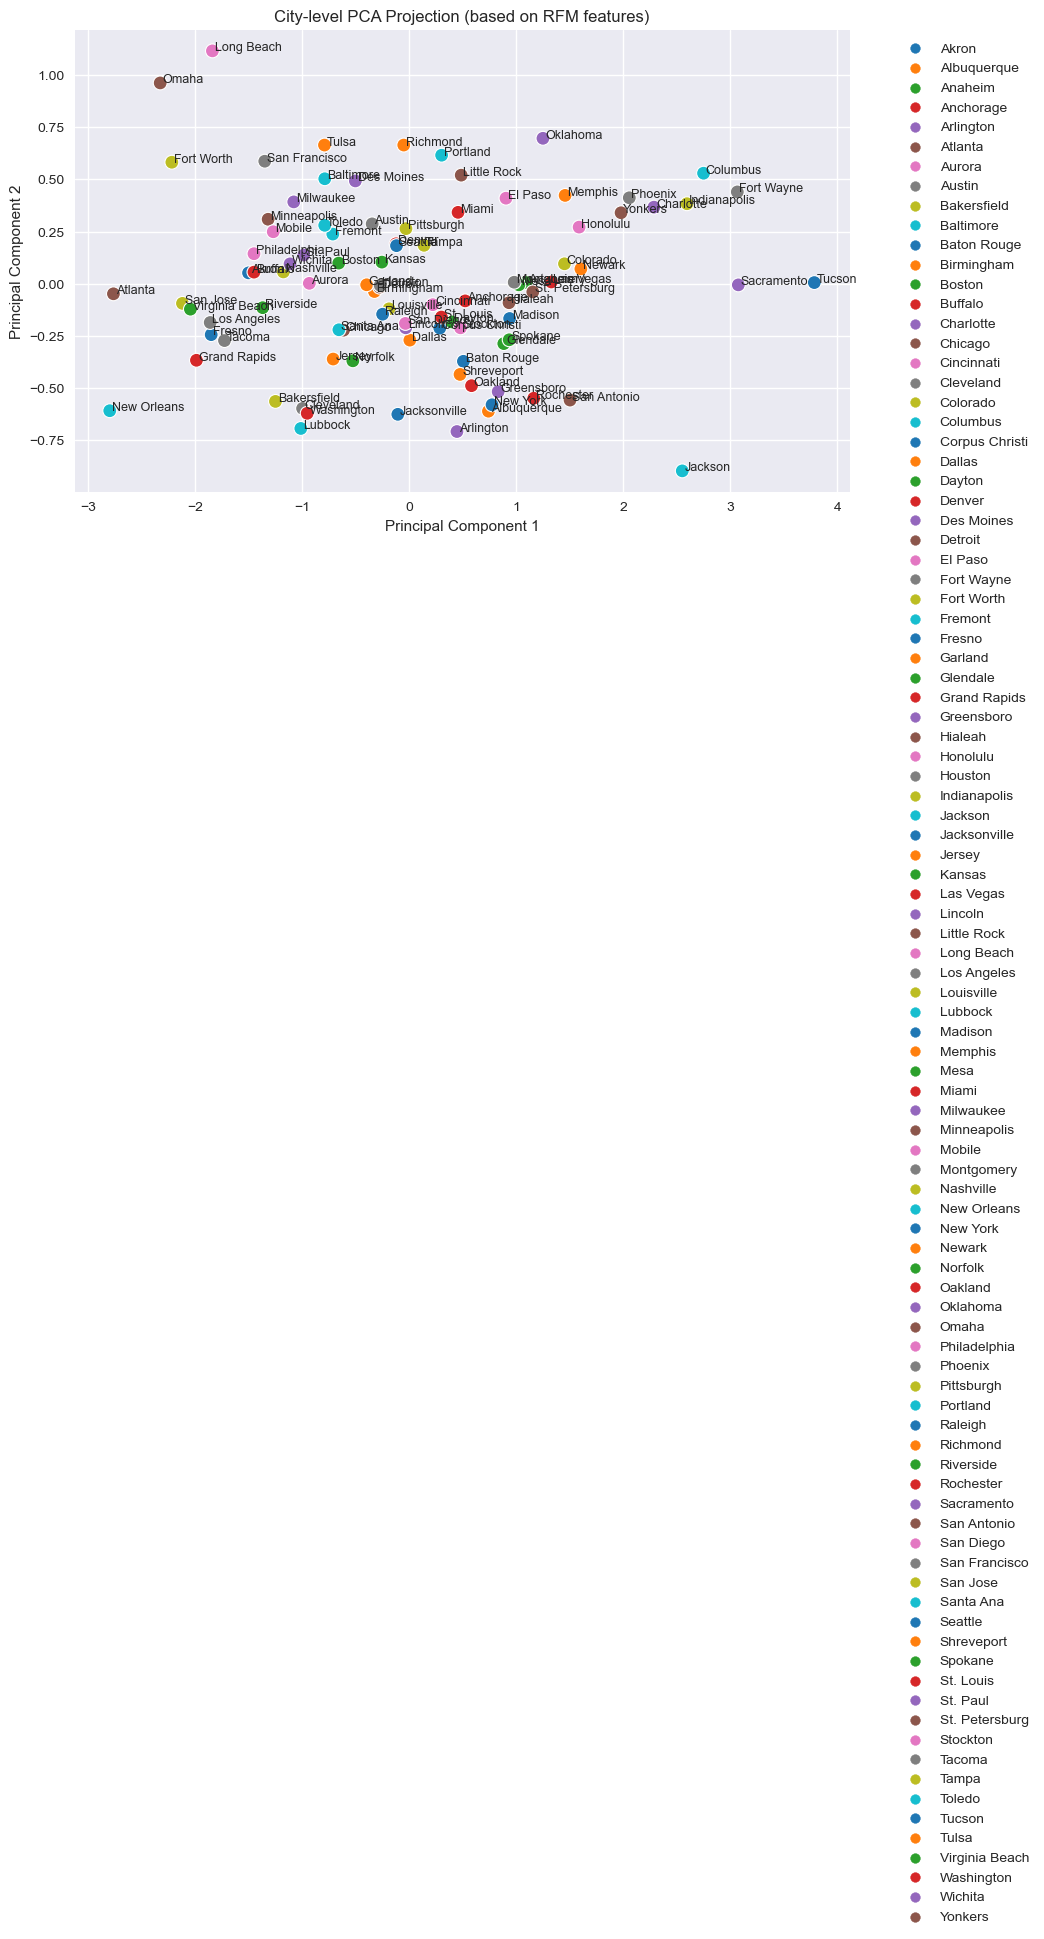

In [25]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm_city, x="PC1", y="PC2", hue="cityname", s=100, palette="tab10")

for i in range(rfm_city.shape[0]):
    plt.text(
        rfm_city["PC1"][i]+0.02,
        rfm_city["PC2"][i],
        rfm_city["cityname"][i],
        fontsize=9
    )

plt.title("City-level PCA Projection (based on RFM features)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Interpretation

Each point represents a **city**, positioned according to its RFM characteristics:

- **PC1** separates cities based on overall customer activity (frequency and monetary).
- **PC2** captures differences related to customer recency and engagement recency.
- Cities located close to each other have **similar customer behavior**.
- Outliers on the edges indicate cities with distinctive purchase patterns — for example, higher spending or more inactive customers.

This visualization helps identify **clusters of cities** with similar customer profiles and can support regional marketing or operational strategies.